# Credit card fraud transactions detection & classifiers comparison 

## Case study

The client (bank) decided to invest in a new prediction model for potential fraudulent transactions detection.<br>
For the provided dataset each record constitutes a set of attributes for each transaction with a flag of either being normal or fraudulent.<br>
Fraudulent cases constitute a small percentage of the overall transactions.<br>


Each time the predictive model results in false positive prediction (predicted fraud but was normal transaction) the bank loses its good reputation (satisfactory ratings) and around £1k.<br>
They have an annual allowance budget £30k to cover these cases. 


Each false negative case (predicted normal transaction but was fraud) harm the bank’s reputation and cost £10 each.<br>
The annual allowance for these cases is £50k.


Requirements: 

1. Predict more than 90% of actual fraudulent cases 
2. Ensure that at least 70% of the predicted cases are actually fraudulent.

<br><br>

## Aims, objectives and plan



The **ultimate goal** of the project is to detect anomalies in financial transactions; specifically credit card transactions.
The secondary goals are: 
* Complete the project within the allocated budget which is £1 million. 
* Capture >90% of the fraudulent cases from the actual cases that are fraudulent transactions.
* The model's performance in predicting fraudulent cases is to give a 70% probability of the predicted cases to be actually fraudulent. This translates to a Precision score of >70%.


The **main objective** that will help to achieve this is to build the machine learning model to detect these anomalies/ potential fraudulent transactions.

Other objectives that will help to succeed in the goal of the project are:  
* Minimise the transactions that are detected as fraudulent but in reality are not - minimise false positive cases.
* Minimise the transactions that are detected as not fraudulent but in reality they are - minimise false negative cases.
* Constraint the maximum count of false negatives to 5.
* Constraint the maximum count of false positives to 30.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
np.random.seed(42)


In [2]:
#Import the data in dataframe
df = pd.read_csv("data/creditcard dataset small.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V28.1,Amount,Normal
0,18088,NaN,3.854150,-12.466766,9.648311,-2.726961,-4.445610,-21.922811,0.320792,-4.433162,...,-1.504119,-19.254328,0.544867,-4.781606,-0.007772,3.052358,-0.775036,-0.775036,1218.89,0
1,101051,NaN,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,1.992110,...,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,0.424849,0.92,0
2,132688,NaN,1.861373,-4.310353,2.448080,4.574094,-2.979912,-2.792379,-2.719867,-0.276704,...,-0.348904,-3.979948,-0.828156,-2.419446,-0.767070,0.387039,0.319402,0.319402,1.00,0
3,95559,NaN,11.614801,-19.739386,10.463866,-12.599146,-1.202393,-23.380508,-5.781133,-7.811022,...,1.140910,1.392953,0.348997,-2.167510,-0.798754,-2.942775,-0.462680,-0.462680,1.63,0
4,58642,-0.451383,2.225147,-4.953050,4.342228,-3.656190,-0.020121,-5.407554,-0.748436,-1.362198,...,0.495889,1.154128,-0.016186,-2.079928,-0.554377,0.455179,0.001321,0.001321,113.92,0


## Data Pre-processing - Feature Engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    9997 non-null   int64  
 1   V1      9993 non-null   float64
 2   V2      9997 non-null   float64
 3   V3      9997 non-null   float64
 4   V4      9997 non-null   float64
 5   V5      9997 non-null   float64
 6   V6      9997 non-null   float64
 7   V7      9997 non-null   float64
 8   V8      9997 non-null   float64
 9   V9      9997 non-null   float64
 10  V10     9997 non-null   float64
 11  V11     9997 non-null   float64
 12  V12     9997 non-null   float64
 13  V13     9997 non-null   float64
 14  V14     9997 non-null   float64
 15  V15     9997 non-null   float64
 16  V16     9997 non-null   float64
 17  V17     9997 non-null   float64
 18  V18     9997 non-null   float64
 19  V19     9997 non-null   float64
 20  V20     9997 non-null   float64
 21  V21     9997 non-null   float64
 22  

dropping the 4 null values from the dataset.

In [4]:
df = df[~(df['V1'].isnull())]

From the target variable is clear that the dataset is imbalanced (95% 'healthy' transactions, 5% 'fraudulent'. <br>
It is important to perform stratified sampling in train-test split to ensure the target variable included in the splits is representative of the complete dataset.

In [5]:
df.Normal.value_counts()

1    9505
0     488
Name: Normal, dtype: int64

The target label is named 'Normal' and this translates to 1 for healthy transactions and 0 for fraudulent transactioins.<br>
In classification problems is usually vice versa, hence I will reverese the labelling -- 1 for fraudulent transaction and 0 for 'healthy' transactions.<br>
This will help to get meaningful results from the evaluation metrics as well such as False Positive or False Negative counts.

In [6]:
#invert the target variable
Fraud = np.logical_xor(df.Normal,1).astype(int)
#create new column in dataframe with inverted target variable
df['Fraud'] = Fraud
#drop the old target variable column
df = df.drop('Normal', axis=1)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V28.1,Amount,Fraud
4,58642,-0.451383,2.225147,-4.953050,4.342228,-3.656190,-0.020121,-5.407554,-0.748436,-1.362198,...,0.495889,1.154128,-0.016186,-2.079928,-0.554377,0.455179,0.001321,0.001321,113.92,1
5,7740,1.023874,2.001485,-4.769752,3.819195,-1.271754,-1.734662,-3.059245,0.889805,0.415382,...,-0.054196,0.709654,-0.372216,-2.032068,0.366778,0.395171,0.020206,0.020206,1.00,1
6,7672,0.702710,2.426433,-5.234513,4.416661,-2.170806,-2.667554,-3.878088,0.911337,-0.166199,...,-0.009802,0.721698,0.473246,-1.959304,0.319476,0.600485,0.129305,0.129305,1.00,1
7,8451,0.314597,2.660670,-5.920037,4.522500,-2.315027,-2.278352,-4.684054,1.202270,-0.694696,...,0.064038,0.677842,0.083008,-1.911034,0.322188,0.620867,0.185030,0.185030,1.00,1
8,8528,0.447396,2.481954,-5.660814,4.455923,-2.443780,-2.185040,-4.716143,1.249803,-0.718326,...,0.140168,0.665411,0.131464,-1.908217,0.334808,0.748534,0.175414,0.175414,1.00,1


Using pearson corellation coefficient method for all fetaures in relation to the target variable.<br>
The feature 'Time' is not very useful in this analysis and it will be excluded.

In [8]:
#take the absolute value corellation coefficient
cor = df.corr().abs()
sort_cor = cor.unstack()['Fraud'].sort_values()[-2::-1]
sort_cor

V14       0.742986
V12       0.697155
V17       0.644026
V10       0.627874
V11       0.600049
V16       0.552992
V25       0.545938
V3        0.526394
V4        0.444572
V7        0.424911
V9        0.400542
V18       0.399196
V5        0.294629
V1        0.259606
V2        0.256588
Time      0.198727
V6        0.175390
V19       0.099505
V21       0.098844
V8        0.073820
V22       0.053194
V26       0.049558
V20       0.048375
V13       0.035628
V27       0.035209
Amount    0.029027
V24       0.025652
V28       0.014705
V28.1     0.014705
V23       0.014573
V15       0.001810
dtype: float64

To eliminate the noisy attributes we pick only the features with correlation more than 0.3.

In [9]:
def get_attributes(df, p_th=0.5):
    """
    Receives the dataframe and threshold for pearsons corellation coefficient.
    Returns the attributes which are correlated to the 'Fraud' target value with corellation 
    coefficient higher than p_th.
    """

    #filter relevant attributes
    cor = df.corr().abs()
    sort_cor = cor.unstack()['Fraud'].sort_values()[-2::-1]
    classification_attributes = sort_cor.index[sort_cor>p_th]
    return classification_attributes

attributes = get_attributes(df, p_th=0.3)
df2 = df[attributes]

Checking for multicollinearity

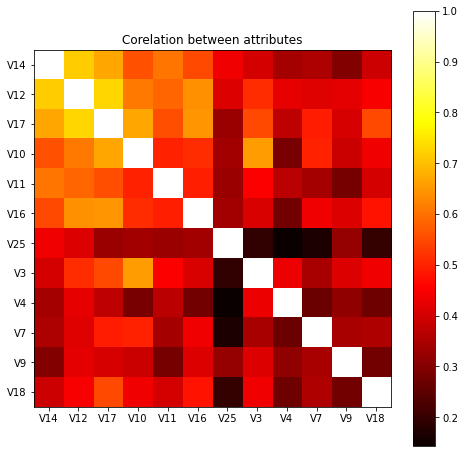

In [10]:
#get correlation table of attributes
fig = plt.figure(figsize=(8,8))
cor_array = np.asarray(df[attributes].corr().abs())
plt.imshow(cor_array,cmap='hot',interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=range(len(attributes)),labels=attributes)
plt.yticks(ticks=range(len(attributes)),labels=attributes)
plt.title("Corelation between attributes")
plt.show()

Some of the features are apear as highly correlated.<br>
We will find those pairs and exclude the feature with the lowest correlation against the target.

In [11]:
cor_table = df2.corr()
cor_table[(cor_table>0.7) & (cor_table<1)].stack().index

MultiIndex([('V14', 'V12'),
            ('V12', 'V14'),
            ('V12', 'V17'),
            ('V17', 'V12')],
           )

In [12]:
#check pairs of features (V14, V12) and (V12, V17) against 'Fraud' target
highly_correlated_features = ['V12' , 'V14', 'V17', 'Fraud']
df[highly_correlated_features].corr().abs()


,V12,V14,V17,Fraud
V12,1.000000,0.716343,0.731324,0.697155
V14,0.716343,1.000000,0.671117,0.742986
V17,0.731324,0.671117,1.000000,0.644026
Fraud,0.697155,0.742986,0.644026,1.000000


In [13]:
attributes=attributes.delete([1,2])
attributes

Index(['V14', 'V10', 'V11', 'V16', 'V25', 'V3', 'V4', 'V7', 'V9', 'V18'], dtype='object')

From the table below is obvious that the attributes are all very similar between them with similar means and standard deviation. Nevertheless, as I intend to use the classification kNN technique which is based on the Eucledian distance metric to estimate the nearest neighbours, the better approach to this is to standardise the features by removing the mean and scaling to unit variance.

In their work Introduction to Data Mining,  Tan et al clarify that "the goal of standardization or normalization is to make an entire set of valueshave a particular property" (Tan et al,2019 p.90). 

In [14]:
df2.describe()

,V14,V12,V17,V10,V11,V16,V25,V3,V4,V7,V9,V18
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,-0.327642,-0.309469,-0.279621,-0.196385,0.047457,-0.311806,-1.294255,-0.574743,0.382937,-0.142244,-0.205477,-0.063948
std,2.031306,1.931530,2.245892,1.973955,1.414597,1.566785,0.565517,2.772772,2.114182,2.855391,1.343731,1.233268
min,-19.214325,-18.683715,-25.162799,-24.588262,-3.684586,-14.129855,-10.295397,-31.103685,-5.266509,-43.557242,-13.434066,-9.498746
25%,-0.647153,-0.541667,-0.560686,-0.687764,-0.861597,-0.845986,-1.478560,-1.182241,-0.864529,-0.526122,-0.860186,-0.579886
50%,-0.019323,0.067766,-0.014330,-0.096776,-0.050266,-0.162495,-1.207500,0.044466,-0.136490,0.183330,-0.126579,0.052822
75%,0.520247,0.578948,0.481993,0.653108,0.685993,0.510768,-1.057588,0.857215,1.128120,0.817537,0.553565,0.644404
max,7.754599,4.472921,6.739384,23.745136,12.018913,7.059132,2.208209,9.382558,16.875344,31.527244,15.594995,5.041069


## Model 1 development 

Since the problem at hand is a classification problem, I intend to use KNN machine learning algorith as my first technique. The reasons are:
* Thisis a simple model hence, it performs good on relatively small datasets.
* KNN is easy to interpret and is based on the simple Eucledian distance. The features have been standardise and ready to apply KNN algorithm. 
* KNN performs well with small numbers of features (attributes).
* KNN can be an extremely fast algorithm.


### Schematic figure of the process 

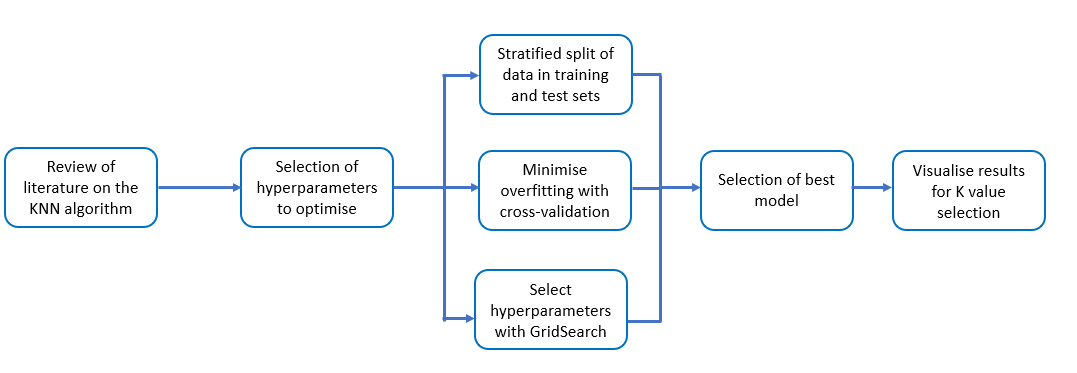

First I will standardise my dataset as explained above.

In [15]:
scaler = StandardScaler()
df2_scaled  = scaler.fit_transform(df2)
processed_data = pd.DataFrame(df2_scaled)
processed_data.columns = df2.columns
processed_data.head()

,V14,V12,V17,V10,V11,V16,V25,V3,V4,V7,V9,V18
0,-2.157762,-2.027901,-2.605895,-2.013439,2.626216,-2.825850,-1.389371,-1.579115,1.872823,-1.844082,-0.860871,-1.915270
1,-2.423027,-3.560559,-0.459724,-1.904611,2.491717,-1.486983,-1.304736,-1.513005,1.625418,-1.021628,0.462064,-0.265786
2,-3.168412,-4.068335,-1.547127,-2.438306,3.271961,-2.233955,-1.176060,-1.680630,1.908032,-1.308413,0.029232,-0.798917
3,-3.619048,-4.253833,-2.477823,-2.700244,4.676465,-2.659292,-1.090702,-1.927876,1.958095,-1.590689,-0.364093,-0.842343
4,-3.294725,-4.233062,-2.675568,-2.631370,4.529243,-2.768903,-1.085720,-1.834383,1.926603,-1.601927,-0.381680,-1.034186


K is a  of the neighrest neighbours we want to achieve to make a valid conclusion on the label of the instance. 
Since the data is imbalanced, a good approach is to use stratified cross-validation.

### Optimising hyper parameters 

In this section I will perform GridSearch with stratified cross-validation to find out about the best hyperparameters (based on my selected ranges). This method will help me to prevent overfitting on the training data by training on a series of multiple splits, holding out a validation set for testing. 

In [16]:
#set training dataset
X = processed_data.values
y = df.Fraud

#perform stratified split on the data to preserve the class proportionality
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# create instance of KNN 
knn = KNeighborsClassifier()

#perform gridsearch to identify the optimum 
model_parameters = {'n_neighbors':list(range(1,51,5))}
test_model_KNN = GridSearchCV(estimator=knn, param_grid=model_parameters, scoring = 'f1', cv=10, n_jobs=-1) # use f1 score as a metric for imbalanced dataset
test_model_KNN.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]},
             scoring='f1')

Let's look at the best estimator and the best score that has achieved.

In [17]:
print(test_model_KNN.best_estimator_)
print(test_model_KNN.best_score_)

KNeighborsClassifier(n_neighbors=1)
0.9779173080971881


## Performance metrics for training

Using the above best estimator I will train this using the training dataset to retrieve the performance metrics for training.

In [18]:
#use best estimator for predicting the labels on the training set
y_pred_train = test_model_KNN.best_estimator_.predict(X_train)
#print classification report
print(classification_report(y_train, y_pred_train))
print(f'\nThe F1 score for the KNN classifier on training dataset is: {f1_score(y_train, y_pred_train):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7604
           1       1.00      1.00      1.00       390

    accuracy                           1.00      7994
   macro avg       1.00      1.00      1.00      7994
weighted avg       1.00      1.00      1.00      7994


The F1 score for the KNN classifier on training dataset is: 1.0



It is clear that the best estimator KNN model trained on the training dataset performs exceptionally well with a macro F1 score=1. 

The weighted F1 score favours the label in the dataset which appears more frequently by setting the weight of this equal to the proportion of the label with respect to the data size. In this application, since the fraudulent instances account only for 5% of the dataset, using the weighted F1 score will tend to give higher score since the non-fraudulent instances account for apprx. 95%. Therefore the model will predict the most frequent label most of the time (depending on model selection and parameters) and it will not give a good indication of the performance on the unbalanced dataset.
<p>
From the graph below of the scoring against the K values it can be seen that the highest performance is achieved by the model when the value K is equal to 1.  

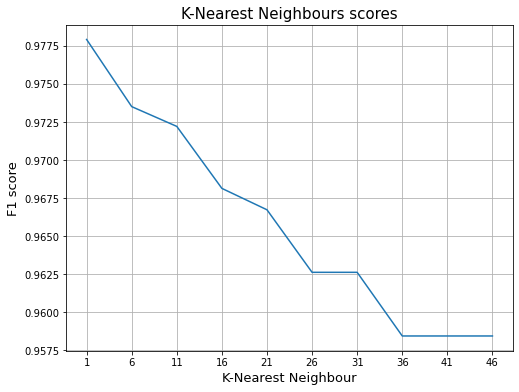

In [19]:
#plot the scoring graph 
scores = test_model_KNN.cv_results_['mean_test_score']
k_values = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
fig = plt.figure(figsize=(8,6))
plt.plot(k_values, scores)
plt.xticks(k_values, labels=k_values)
plt.ylabel('F1 score', fontdict={'fontsize':13})
plt.xlabel('K-Nearest Neighbour', fontdict={'fontsize':13})
plt.title('K-Nearest Neighbours scores', fontdict={'fontsize':15})
plt.grid()

## Model 2 Devlopment

Deploying RandomForest machine learning algorith as second model. The reasons for using RandomForest:
1. Ensemble machine learning models take advantage of their agregated decisions which are based on samping methods of the input dataset by diversifying the properties of each sub-model within the ensemble and exposing various dynamics for each data split. This will enable to take a more sophisticated approach towards classification with the method of  'model voting'.
2. Due to the random sampling of the data attributes for each sub-model of the ensemble, this method promotes diverisity among the predictors (Tan et al,2019). 
3. Random Forest classifier, due to its underlying functionality has low bias and reduced variance. As a result this makes the Random Forest classification model robust to overfitting.
4. With Random Forest classifier, standardisation or normalisation of data is not required since the model operates on a rule-based approach. This makes the model robust to datasets which exhibit high variety of the scales among all attributes. 

### Schematic figure of the process 

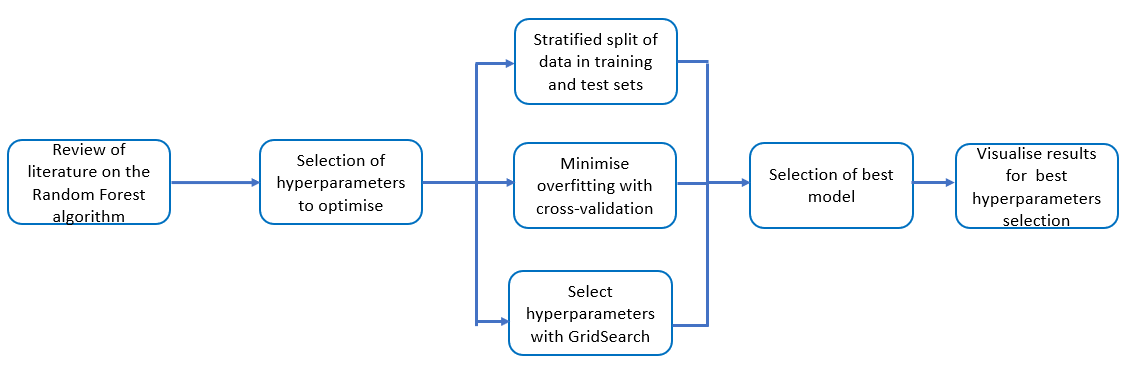

The ensemble model Random Forest, is a robust model when it comes to overfitting. It enables to adjust its parameters so that the trees do not overgrow and prevent overfitting. I have selected the following hyperparameters to tune and compare with the method of GridSearch:
* _Number of estimators_: by introducing a variety of estimators in the ensemble model, it promotes the decorrelation of the sub-models to enhance the aggregate decision from each participant tree. Setting parameters such as bootstrap to 'True', will further infuse diversity among the trees and help to improve the results.
* _Maximum depth_: If a tree is allowed to fully grow, then it will make splits at each node until the impurity reaches 0. However, this is not a good approach because if the model is used on unseen data, the same splits performed while training the model may not follow exactly the same route with the new data. Therefore the model will not be able to generalise well on the new data.
* _Maximum leaf nodes_: Limiting the number of leaf nodes is a pre-pruning technique to prevent the tree from fully growing which helps to avoid overfitting of the model. 

References:

Scikit-learn developers 2020. Random Forest classifier website. [Online]. [Accessed 25 June 2021]. Available from: https://scikit-learn.org 



### Optimising hyper parameters


Performing GridSearch with stratified cross-validation to find out about the best hyperparameters.

In [20]:
# create instance of RandomForest 
RF = RandomForestClassifier()

# perform gridsearch to identify the optimum 
model_parameters = {'n_estimators':list(range(1,100,20)), 
                    'max_depth': list(range(2,20,2)),
                    'max_leaf_nodes': list(range(2,10,2)) }
test_model_RF = GridSearchCV(estimator=RF, param_grid=model_parameters, scoring = 'f1', cv=10, n_jobs=-1) # use f1 score as a metric for imbalanced dataset
test_model_RF.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_leaf_nodes': [2, 4, 6, 8],
                         'n_estimators': [1, 21, 41, 61, 81]},
             scoring='f1')

Viewing the best hyperpatameters and best scores that the estimator has computed.

In [21]:
print(test_model_RF.best_params_)
print(test_model_RF.best_score_)

{'max_depth': 4, 'max_leaf_nodes': 6, 'n_estimators': 61}
0.9961367746177873


In [22]:
#create a dataframe from the model hyperparameters and scores
RF_grid_results = pd.DataFrame(test_model_RF.cv_results_['params'])
RF_grid_results['F1_score'] = test_model_RF.cv_results_['mean_test_score']
RF_grid_results['Combined_parameters'] = RF_grid_results.apply(lambda x:'%s, %s, %s' % (int(x['max_depth']),int(x['max_leaf_nodes']),int(x['n_estimators'])),
                                                               axis=1)
RF_grid_results.head()

,max_depth,max_leaf_nodes,n_estimators,F1_score,Combined_parameters
0,2,2,1,0.839362,"2, 2, 1"
1,2,2,21,0.878409,"2, 2, 21"
2,2,2,41,0.887289,"2, 2, 41"
3,2,2,61,0.889388,"2, 2, 61"
4,2,2,81,0.888527,"2, 2, 81"


### Performance metrics for training

Using the above best estimator I will train this using the training dataset to retrieve the performance metrics for training.

In [23]:
#use best estimator for predicting the labels on the training set
y_pred_train = test_model_RF.best_estimator_.predict(X_train)
#print classification report
print(classification_report(y_train, y_pred_train))
print(f'\nThe F1 score for the Random Forest classifier on training dataset is: {f1_score(y_train, y_pred_train):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7604
           1       1.00      0.99      1.00       390

    accuracy                           1.00      7994
   macro avg       1.00      1.00      1.00      7994
weighted avg       1.00      1.00      1.00      7994


The F1 score for the Random Forest classifier on training dataset is: 0.997



Plotting F1_score for each of the hyperparameters combination as it is shown in the dataframe above.
<p>The column 'Combined_parameters' in the dataframe includes entries of three integers which represent the ( _max_depth, max_leaf_nodes, n_estimators_ ). 
<p>The same for the graph below, each value of the X-axis represents this tuple of hyperparameters.

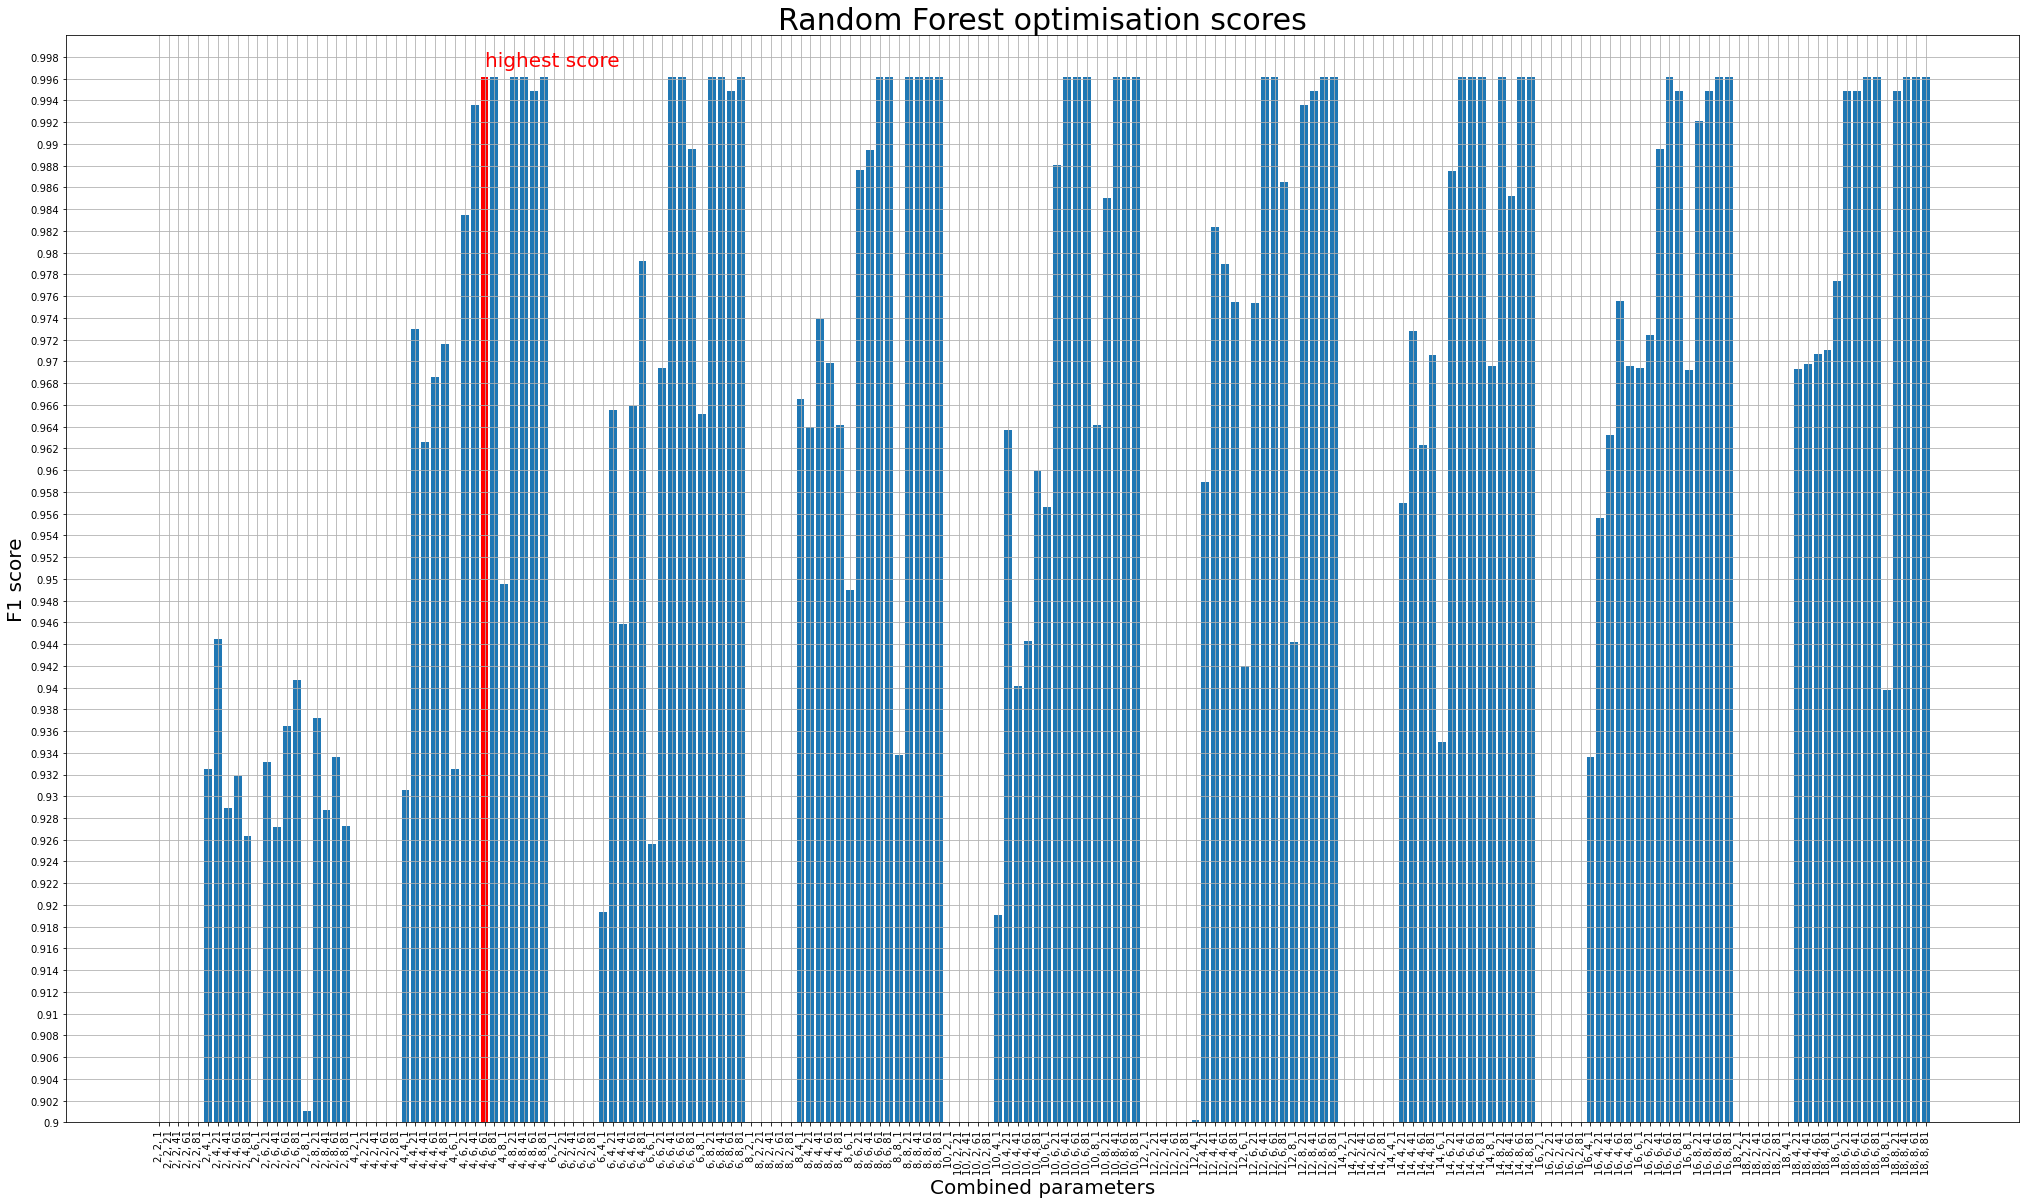

In [24]:
#plot the scoring graph 
scores = RF_grid_results.F1_score
combined_params = RF_grid_results.Combined_parameters
fig = plt.figure(figsize=(35,20))
plt.bar(combined_params, scores)
plt.xticks(combined_params, labels=combined_params,rotation=90)
plt.yticks(np.arange(0.9,1,0.002).round(3), labels=np.arange(0.9,1,0.002).round(3))
plt.ylabel('F1 score', fontdict={'fontsize':20})
plt.xlabel('Combined parameters', fontdict={'fontsize':20})
plt.ylim(0.9, 1)
#find the maximum score index
max_idx = RF_grid_results.F1_score.idxmax()
x = RF_grid_results.Combined_parameters[max_idx]
y = RF_grid_results.F1_score[max_idx]
#highlight in red the maximum socre on graph
plt.bar(x, y, color='red')
plt.annotate('highest score', xy=(x,y+0.001), fontsize=20, color='red')
plt.title('Random Forest optimisation scores', fontdict={'fontsize':30})
plt.grid()


## Comparison of metrics performance for testing 



### Use of cross validation for both techniques to deal with over-fitting

Viewing the cross validation scores for each of the estimators.

In [25]:
print('The averaged cross-validation scores for each run for the KNN classifer are:\n')
print(test_model_KNN.cv_results_['mean_test_score'],'\n')

The averaged cross-validation scores for each run for the KNN classifer are:

[0.97791731 0.97350642 0.97220772 0.96813709 0.96673168 0.96262498
 0.96262498 0.95844423 0.95844423 0.95844423] 



In [26]:
print('The averaged cross-validation scores for each run for the Random Forest classifer are:\n')
print(test_model_RF.cv_results_['mean_test_score'],'\n')

The averaged cross-validation scores for each run for the Random Forest classifer are:

[0.83936153 0.87840879 0.88728899 0.88938778 0.88852739 0.93251268
 0.9445065  0.92894992 0.93183935 0.92631834 0.88180549 0.93313664
 0.9271671  0.93650551 0.9406961  0.90102768 0.93716333 0.92874702
 0.93364306 0.92724902 0.80701376 0.87565066 0.8882658  0.88488854
 0.88340821 0.93061675 0.97299719 0.96259229 0.96860341 0.97163577
 0.93248681 0.98343674 0.99357225 0.99613677 0.99613677 0.94949682
 0.99613677 0.99613677 0.99483807 0.99613677 0.85135793 0.88642756
 0.88484056 0.88679067 0.88983842 0.9193692  0.96550425 0.94587628
 0.96593951 0.97921011 0.92561856 0.96935456 0.99613677 0.99613677
 0.9895052  0.96514432 0.99613677 0.99613677 0.99487095 0.99613677
 0.87596651 0.88778749 0.88169593 0.88330905 0.88970339 0.96653228
 0.96397843 0.97391141 0.96983758 0.96417218 0.94896737 0.98757632
 0.98946555 0.99613677 0.99613677 0.93379128 0.99613677 0.99613677
 0.99613677 0.99613677 0.76441775 0.87661

### Comparison with appropriate metrics for testing

1. Evauating of the two classifiers using the stratified X_test & y_test dataset obtained previously.
2. Calculating the confusion matrix to understand how the models perform in relation to the business demands; meaning mimimise the False Negatives and False Positives instances.

In [27]:
#Evaluation metrics for KNN model
#use best estimator for predicting the labels on the testing set
y_pred_KNN = test_model_KNN.best_estimator_.predict(X_test)
#print classification report
print(classification_report(y_test, y_pred_KNN))
print(f'\nThe fraudulent class F1 score for the KNN classifier on testing dataset is: {f1_score(y_test, y_pred_KNN):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1901
           1       0.99      0.95      0.97        98

    accuracy                           1.00      1999
   macro avg       0.99      0.97      0.98      1999
weighted avg       1.00      1.00      1.00      1999


The fraudulent class F1 score for the KNN classifier on testing dataset is: 0.969



In [28]:
#Evaluation metrics for RF model
#use best estimator for predicting the labels on the testing set
y_pred_RF = test_model_RF.best_estimator_.predict(X_test)
#print classification report
print(classification_report(y_test, y_pred_RF))
print(f'\nThe fraudulent class F1 score for the Random Forest classifier on testing dataset is: {f1_score(y_test, y_pred_RF):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1901
           1       1.00      0.97      0.98        98

    accuracy                           1.00      1999
   macro avg       1.00      0.98      0.99      1999
weighted avg       1.00      1.00      1.00      1999


The fraudulent class F1 score for the Random Forest classifier on testing dataset is: 0.984



Both models have good enough scores to cover the previously mentioned criteria
Reminder:
* Achieve a Recall of >90% (with respect to the fraudulent class-1) - **achieved for both models**
* Achieve a Precision of >70% (with respect to the fraudulent class-1) - **achieved for both models**

However the Random Forest classifier outperforms the KNN classifier.

Below I will compare the models with respect to the financial losses.

In [29]:
#function to plot the confusion matrix
def plot_confusion_matrix(ytrue, ypred, labels,title, normalise=False):
    """
    This function plots confusion matrix. 
    If Normalize='True' plot with normalised values.

    """
    cm = confusion_matrix(ytrue, ypred, labels=labels)
    plt.figure(figsize=(5,5))
    if normalise:
        cm = cm/ cm.sum(axis=1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    #format and show values in the matrix 
    if normalise:
        type_format = '.2f'
    else:
        type_format = 'd'
    #set threshold for value visibility
    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], type_format), horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    
#function to retrieve FP,FN,TP,TN counts
def class_predictions(ytrue, ypred, labels):
    """
    Accepts the labels in [1,0] format. True label first.
    Returns TP, FP, TN, FN

    """    
    cm = confusion_matrix(ytrue, ypred, labels=labels)
    TP=FP=TN=FN = 0
    #get the TP 
    TP = cm[0,0]
    #get the TN
    TN = cm[1,1]
    #get the FN
    FN = cm[0,1]
    #get the FP
    FP = cm[1,0]
    return TP,FP,TN,FN
    

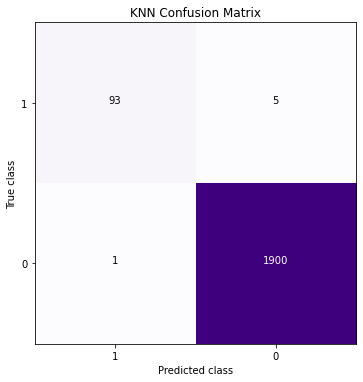

In [30]:
#plot confusion matrix for KNN classifier
plot_confusion_matrix(y_test, y_pred_KNN, labels=[1,0], title='KNN Confusion Matrix', normalise=False)
TP, FP, TN, FN = class_predictions(y_test, y_pred_KNN, labels=[1,0])


In [31]:
print(f'KNN classifier returns {FP} False Positives. At the cost of £1k for each FP the financial loss = £1k x {FP} = £{1*FP}k\n')
print(f'KNN classifier returns {FN} False Negatives. At the cost of £10k for each FP the financial loss = £10k x {FN} = £{10*FN}k\n')
print(f'The total financial loss for the KNN model is £{10*FN}k + £{1*FP}k = £{1*FP + 10*FN}k')

KNN classifier returns 1 False Positives. At the cost of £1k for each FP the financial loss = £1k x 1 = £1k

KNN classifier returns 5 False Negatives. At the cost of £10k for each FP the financial loss = £10k x 5 = £50k

The total financial loss for the KNN model is £50k + £1k = £51k


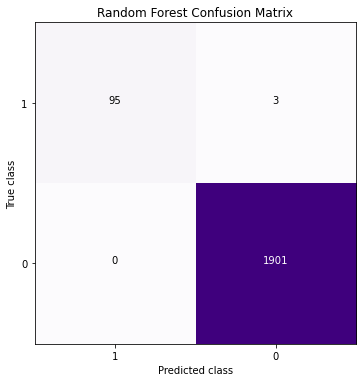

In [32]:
#plot confusion matrix for Random Forest classifier
plot_confusion_matrix(y_test, y_pred_RF, labels=[1,0], title='Random Forest Confusion Matrix', normalise=False)
TP, FP, TN, FN = class_predictions(y_test, y_pred_RF,labels=[1,0])


In [33]:
print(f'RF classifier returns {FP} False Positives. At the cost of £1k for each FP the financial loss = £1k x {FP} = £{1*FP}k\n')
print(f'RF classifier returns {FN} False Negatives. At the cost of £10k for each FP the financial loss = £10k x {FN} = £{10*FN}k\n')
print(f'The total financial loss for the RF model is £{10*FN}k + £{1*FP}k = £{1*FP + 10*FN}k\n')

RF classifier returns 0 False Positives. At the cost of £1k for each FP the financial loss = £1k x 0 = £0k

RF classifier returns 3 False Negatives. At the cost of £10k for each FP the financial loss = £10k x 3 = £30k

The total financial loss for the RF model is £30k + £0k = £30k



Its is obvious that Random Forest classifier will tend to be the better option for this application and achieve higher financial savings.

### Model selection  - comparison

The Area Under Curve score and the ROC curves are good method to compare different classification models. Particularly in this problem, since we care more about the False Negative predictions because they cost more money to the bank, we want to compare and identify whiuch model minimises best the False Negatives. For this reason we expect to see on the ROC curve a high True Positive rate which will push the ROC curve towards the uppper left corner of the graph.  

References:

Scikit-learn developers 2020. Receiver Operating Characteristic website. [Online]. [Accessed 25 June 2021]. Available from: https://scikit-learn.org 

In [34]:
#calculate KNN probabilities 
y_prob_test_KNN = test_model_KNN.best_estimator_.predict_proba(X_test)

In [35]:
#calculate RF probabilities 
y_prob_test_RF = test_model_RF.best_estimator_.predict_proba(X_test)

The KNN ROC Area Under Curve is 0.974
The Random Forest ROC Area Under Curve is 1.000


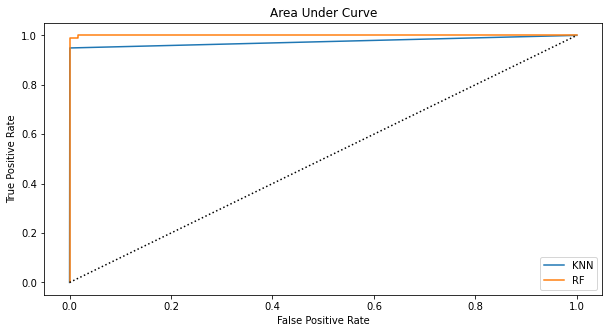

In [36]:
# calculate the Area Under Curve scores
KNN_auc_score = roc_auc_score(y_test,y_prob_test_KNN[:, 1])
RF_auc_score = roc_auc_score(y_test, y_prob_test_RF[:, 1])
# print the AUC scores
print(f'The KNN ROC Area Under Curve is {KNN_auc_score:.3f}')
print(f'The Random Forest ROC Area Under Curve is {RF_auc_score:.3f}')      
# calculate the ROC curves
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test,y_prob_test_KNN[:, 1])
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_prob_test_RF[:, 1])
# plot the ROC curves for each model
plt.figure(figsize=(10,5))
plt.plot(fpr_KNN, tpr_KNN, label='KNN')
plt.plot(fpr_RF, tpr_RF, label='RF')
plt.plot([0, 1], [0, 1], color='k',linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Curve')
plt.legend()
plt.show()

From the ROC graph, both models perform really well for this problem. Especially the Random Forest classifier performs even better than the KNN classifier and this is also demonstarted by the calculated areas under curve, in which Random Forest classifier achieves a higher score. 

## Final recommendation of best model

* In this problem, both models KNN classifier and Random Forest classifier performed well on classifying the fraudulent credit card transactions.
* Even though both estimators achieved very high performance metrics, close to 100%, it has been demonstarted that the Random Forest model outperforms the KNN model.
* Both models avoided overfitting as both training and testing performance metrics are similar.
* KNN classifier can be extremely fast, once all distances between the points (samples) have been calculated. However, when a new instance is given to be classified, the algorithm will need to re-estimate all the distances between the samples. During model optimisation the model concludes to the best parameters very fast as the only major parameter to be optimised is the K-Neighbours.
* Random Forest is also a fast algorithm to train but once the best estimator is selected, future instances are faster to calculate than KNN classifier since there is no need to re-train the model. During optimisation process, Random Forest classifier takes significantly more time than the KNN classifier to conclude on the best estimator due to the higher number of model hyperparameters and the combinations that grid search needs to compare.  

### Review results from a business perspective


As it has been demonstrated above, from a business point of view both models are able to achieve the desired Recall (>90%) and Precission (>70%) as specified by the client.

The most important comparison from the financial point of view is the running costs of the models based on their capabilities to minimise the False Positives and False Negatives instances.

The Random Forest classifier achieved substantial financial savings for the bank. 

Based on the overall performance metrics and the financial savings, the recommendatioin to be put forward to the bank, is to deploy the Random Forest classifier. 

## Conclusion

* The project has succesfully proven and concluded that the Random Forest classifier outperforms the KNN classifier and is able to meet the financial expenditures set by the bank. Therefore the recommended model to be deployed is Random Forest Classifier.
* The project succeeded in setting up appropriately the machine learning models to achieve very high performance scores to meet the business requirements.

### Future work

A list of future work I would recommend for further development is:

* Develop a logistic regression model and perform classification with the model. The logistic regression model is ideal to deal with this bulk of data and numerical features. The logistic regresssion model also provides the benefit of using the weights from each feature and perform feature engineering to narrow down the dataset only to the most important features, ie. to the features highly correlated to the target label.
* Perform PCA on the data for dimensionality reduction and draw the explained variance graph. This is a mathematically more sophisticated method to obtaon the attributes which carry the most of information (explained variance) to be used by the model.
* I also recommend to test the above trained machine learning algorithms on larger dataset which will enable for better model optimisation and help with achieving good generalisation. 
* Perform model optimisation including more parameters and consider a higher combination of hyperparameters.